#                            Credit Score Exploration and Prediction


                         Hello 4523-Yichen Yao, Yi Mao, Yuxuan Pan, Meng Li, Yaqi Zheng

# 1. Introduction

Default is a highly bothersome problem in the financial industry which causes huge losses for the lender companies. Thus, it is essential for the financial institutes to estimate the default risk of its customers to minimize the uncertainty in receiving the loan repayments. In this project, after conducting the data cleaning, we apply different machine learning models (logistic regression, KNN, decision tree, random forest) to the customers’ credit-related data to classify them into different credit score categories.


[Data source]

Paris, R. (2022, June). "Credit score classification". Kaggle. Retrieved December 17, 2022, 

from https://www.kaggle.com/datasets/parisrohan/credit-score-classification

SSA.gov  "Social Security Number Allocations". Retrieved December 17, 2022, 
            Web scraping URL: https://www.ssa.gov/employer/stateweb.htm



In [22]:
import re
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [23]:
import warnings
warnings.filterwarnings("ignore")

# 2. Data Cleaning

In [24]:
datafile = "Hello 4523.csv"
df = pd.read_csv(datafile)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [25]:
def data_clean(data_cr):
    #drop unnecessary column(s)
    data_cr.drop(['ID'] ,axis= 1 , inplace = True)
    # drop the completely duplicated data if any
    data_cr.drop_duplicates(inplace = True)
    
    # Using mode for a person to replace missing data in columns"Name", "SSN", "Occupation", 
    #"Interest_Rate", "Credit_Mix"
    def clean_col(df, colname):
        grouped = data_cr.groupby("Customer_ID")[colname].apply(pd.Series.mode)
    
        col_dict = {}

        for i in grouped.index:
            col_dict[i[0]] = grouped[i[0]][0]
        
        df[colname] = df["Customer_ID"].map(col_dict)
    
        return df
    
    col_list = ["Name", "SSN", "Occupation", "Interest_Rate", "Credit_Mix"]
    
    for i in col_list:
        data_cr = clean_col(data_cr, i)
    
    # delete "_" in any data
    data_cr = data_cr.applymap(lambda x: str(x).strip("_"))
    
    # convert numercial data from string to float
    def intofloat(data):
        try:
            return float(data)
        except:
            return np.nan
        
    col_list2 = ['Age', 'Annual_Income',"Monthly_Inhand_Salary", "Num_Bank_Accounts","Num_Credit_Card"
                 , "Interest_Rate", 'Num_of_Loan', "Delay_from_due_date", 'Num_of_Delayed_Payment'
                 , 'Changed_Credit_Limit',"Num_Credit_Inquiries","Credit_Utilization_Ratio"
                 , "Total_EMI_per_month", 'Amount_invested_monthly', 'Outstanding_Debt' , 'Monthly_Balance']
    
    for j in col_list2:
        data_cr[j] = data_cr[j].apply(lambda x:intofloat(x))
    
    #drop unreasonable age value     
    def age1(x):
        for i in range(len(data_cr)):
            if data_cr[x].iloc[i] < 0 or data_cr[x].iloc[i] >80:
                for j in range(1,5):
                    if 0<data_cr[x].iloc[i-j]<80 and data_cr["Customer_ID"].iloc[i] == data_cr["Customer_ID"].iloc[i-j]:
                        data_cr[x].iloc[i] = data_cr[x].iloc[i-j]
                        break
                    elif 0<data_cr[x].iloc[i+j]<80 and data_cr["Customer_ID"].iloc[i] == data_cr["Customer_ID"].iloc[i+j]:
                        data_cr[x].iloc[i] = data_cr[x].iloc[i+j]
                        break
    age1("Age")
    
    # SSN no processing required
    # Occupation
    def tona(data):
        if data == "":
            return "NA"
        return data
    
    data_cr["Occupation"] = data_cr["Occupation"].apply(lambda x: tona(x))
    data_cr = data_cr[data_cr['Occupation'] != 'NA']
    
    occupation = np.array(data_cr["Occupation"]).reshape(-1,1)
    enc = OneHotEncoder(categories = "auto").fit(occupation)
    result = enc.transform(occupation).toarray()
    occ_list = [i.strip("x0_") for i in enc.get_feature_names()]
    data_cr.index = range(len(data_cr))
    data_cr = data_cr.join(pd.DataFrame(result))
    data_cr.drop(["Occupation"], inplace = True, axis = 1)
    col1 = list(data_cr.columns[:-15])
    col_names = col1+occ_list
    data_cr.columns = col_names
    
    # Annual_Income no processing required
    
    # Monthly_Inhand_Salary
    def clean_col2(df, colname):
        grouped = df.groupby("Customer_ID").mean()[colname]
        col_dict = {}

        for i in grouped.index:
            col_dict[i] = grouped[i]
        
        nulcol = df.loc[df[colname].isnull()].copy()
        nulcol[colname] = nulcol["Customer_ID"].map(col_dict)
    
        df.loc[df.loc[:,colname].isnull(), colname] = nulcol[colname]
    
        return df
    
    data_cr = clean_col2(data_cr, "Monthly_Inhand_Salary")
    
    # Num_Bank_Accounts
    def tona2(data):
        if data > 15 or data < 0:
            return np.nan
        return data
    
    data_cr["Num_Bank_Accounts"] = data_cr["Num_Bank_Accounts"].apply(lambda x: tona2(x))
    data_cr = clean_col2(data_cr, "Num_Bank_Accounts")
    data_cr["Num_Bank_Accounts"] = data_cr["Num_Bank_Accounts"].apply(lambda x: round(x))
    
    # Num_Credit_Card
    data_cr["Num_Credit_Card"] = data_cr["Num_Credit_Card"].apply(lambda x: tona2(x))
    data_cr = clean_col2(data_cr, "Num_Credit_Card")
    data_cr["Num_Credit_Card"] = data_cr["Num_Credit_Card"].apply(lambda x: round(x))
    
    # Interest_Rate no processing needed
    
    # Num_of_Loan
    data_cr["Num_of_Loan"] = data_cr["Num_of_Loan"].apply(lambda x: tona2(x))
    data_cr = clean_col2(data_cr, "Num_of_Loan")
    data_cr["Num_of_Loan"] = data_cr["Num_of_Loan"].apply(lambda x: round(x))
    
    # Num_of_Loan and Type_of_Loan
    def sp(x):
        list1 = x.split(',')
        if len(list1) > 1:
            list1[-1] = list1[-1][4:]
            for i in range(len(list1)-1):
                list1[i+1] = list1[i+1][1:]
        return list1
    
    def nan2zero(data):
        if data == ['nan']:
            return []
        return data
    
    def zero2noloan(data):
        if data == []:
            return ['no loan']
        return data
    
    data_cr['Type_of_Loan'] = data_cr['Type_of_Loan'].apply(sp)
    data_cr['Type_of_Loan'] = data_cr['Type_of_Loan'].apply(lambda x: nan2zero(x))
    data_cr['Num_of_Loan'] = data_cr['Type_of_Loan'].apply(lambda x:len(x))
    data_cr['Type_of_Loan'] = data_cr['Type_of_Loan'].apply(lambda x: zero2noloan(x))
    
    # count the number of each 9 loans separately and create the corresponding 10 columns, including no loan
    loanlist = ['Auto Loan','Credit-Builder Loan','Debt Consolidation Loan','Home Equity Loan','Mortgage Loan','Payday Loan','Personal Loan','Student Loan','Not Specified','no loan']
    for loan in loanlist:
        data_cr[loan] = data_cr['Type_of_Loan'].apply(lambda x: np.where(np.array(x) == loan,1,0).sum())

    
    # Delay_from_due_date no processing needed
    # Num_of_Delayed_Payment
    def tona4(data):
        if data > 30 or data < 0:
            return np.nan
        return data
    data_cr["Num_of_Delayed_Payment"] = data_cr["Num_of_Delayed_Payment"].apply(lambda x: tona4(x))
    data_cr = clean_col2(data_cr, "Num_of_Delayed_Payment")
    data_cr["Num_of_Delayed_Payment"] = data_cr["Num_of_Delayed_Payment"].apply(lambda x: round(x))
    
    # Changed_Credit_Limit no processing needed
    data_cr = clean_col2(data_cr, "Changed_Credit_Limit")
    
    
    # Num_Credit_Inquiries
    def tona3(data):
        if data > 20 or data < 0:
            return np.nan
        return data
    data_cr["Num_Credit_Inquiries"] = data_cr["Num_Credit_Inquiries"].apply(lambda x: tona3(x))
    data_cr = clean_col2(data_cr, "Num_Credit_Inquiries")
    data_cr["Num_Credit_Inquiries"] = data_cr["Num_Credit_Inquiries"].apply(lambda x: round(x))
    
    # Credit_Mix
    data_cr = data_cr[data_cr["Credit_Mix"] != '']
    def credit(x):
        if x == "Good":
            return 3
        elif x == "Standard":
            return 2
        elif x == "Bad":
            return 1
        else:
            return np.NaN
    
    data_cr["Credit_Mix"] = data_cr["Credit_Mix"].apply(credit) # 1 = "Bad", 2 = "Standard", 3 = "Good"
    
    # Outstanding_Debt no processing needed
    
    # Credit_Utilization_Ratio no processing needed
    
    # Credit_History_Age
    
    def age(x):
        pattern = r'\d+'
        list1 = re.findall(pattern,x)
        if len(list1) == 2:
            return float(list1[0]) + float(list1[1])/12
        else:
            return "nan"
    
    data_cr["Credit_History_Age"] = data_cr["Credit_History_Age"].apply(age)
    
    def age2(x):
        for i in range(len(data_cr)):
            if data_cr[x].iloc[i] == "nan":
                for j in range(1,5):
                    if data_cr[x].iloc[i-j] != "nan" and data_cr["Customer_ID"].iloc[i] == data_cr["Customer_ID"].iloc[i-j]:
                        data_cr[x].iloc[i] = data_cr[x].iloc[i-j] + j/12
                        break
                    elif data_cr[x].iloc[i+j] != "nan" and data_cr["Customer_ID"].iloc[i] == data_cr["Customer_ID"].iloc[i+j]:
                        data_cr[x].iloc[i] = data_cr[x].iloc[i+j] - j/12
                        break
                        
    age2("Credit_History_Age")
    
    def inv(x):
        if x == 10000:
            return np.NaN
        else:
            return x
    
    data_cr["Amount_invested_monthly"] = data_cr["Amount_invested_monthly"].apply(inv)
    data_cr = clean_col2(data_cr, "Amount_invested_monthly")
    
    # Payment_Behaviour -> convert to Payment_Behaviour_spent and Payment_Behaviour_value_payments

    def sp2(x):
        list1 = x.split("_")
        a = np.NaN
        b = np.NaN
        if len(list1) > 1:
            if list1[0] == 'Low':
                a = 1
            elif list1[0] == 'High':
                a = 2
            if list1[2] == 'Small':
                b = 1
            elif list1[2] == 'Medium':
                b = 2
            elif list1[2] == 'Large':
                b = 3
        return (a,b)
    
    data_cr["Payment_Behaviour"] = data_cr["Payment_Behaviour"].apply(sp2)
    
    data_cr["Payment_Behaviour_spent"] = data_cr["Payment_Behaviour"].apply(lambda x: x[0])  # 1 = 'low spend', 2 = 'high spend'
    data_cr = clean_col2(data_cr, "Payment_Behaviour_spent")
    data_cr["Payment_Behaviour_spent"] = data_cr["Payment_Behaviour_spent"].apply(lambda x: round(x))
    
    data_cr["Payment_Behaviour_value_payments"] = data_cr["Payment_Behaviour"].apply(lambda x: x[1]) #1 =Small_value_payments, 2=medium, 3 = large
    data_cr = clean_col2(data_cr, "Payment_Behaviour_value_payments")
    data_cr["Payment_Behaviour_value_payments"] = data_cr["Payment_Behaviour_value_payments"].apply(lambda x: round(x))
    
    # Monthly_Balance
    data_cr = data_cr[data_cr["Monthly_Balance"] >= 0]
    
    # Credit_Score
    def credit(x):
        if x == "Good":
            return 3
        elif x == "Standard":
            return 2
        elif x == "Poor":
            return 1
        else:
            return np.NaN

    data_cr["Credit_Score"] = data_cr["Credit_Score"].apply(credit)
    
    return data_cr

In [26]:
df = data_clean(df)

In [27]:
df.head()

,Customer_ID,Month,Name,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Payday Loan,Personal Loan,Student Loan,Not Specified,no loan,Payment_Behaviour_spent,Payment_Behaviour_value_payments
0,CUS_0xd40,January,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3,4,3.0,...,0,1,0,0,1,0,0,0,2,1
1,CUS_0xd40,February,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3,4,3.0,...,0,1,0,0,1,0,0,0,1,3
2,CUS_0xd40,March,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3,4,3.0,...,0,1,0,0,1,0,0,0,1,2
3,CUS_0xd40,April,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3,4,3.0,...,0,1,0,0,1,0,0,0,1,1
4,CUS_0xd40,May,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3,4,3.0,...,0,1,0,0,1,0,0,0,2,2


In [28]:
df.to_csv('Cleaned_data.csv')

# 3. Exploratory Data Analysis

## 3.1 Percentage distribution of Credit Scores

In [30]:
df = pd.read_csv('Cleaned_data.csv')

Text(0.5, 1.0, 'Credit scores distribution ')

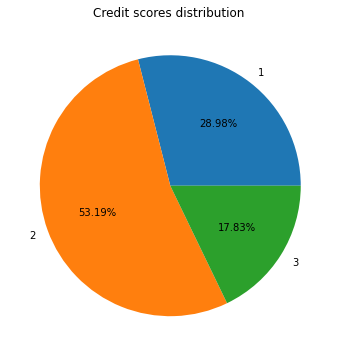

In [31]:
df_count=df.groupby('Credit_Score').count()
figure, axes = plt.subplots(figsize=(6, 6))
plt.pie(df_count['Customer_ID'],labels=[1,2,3],autopct='%1.2f%%') 
plt.title("Credit scores distribution ")

The percentage of 1,2,3 is 28.98%, 53.19% and 17.83%

## 3.2 Location distribution of Credit Scores

In [36]:
#CHANGE SSN INTO LOCATION
def SSN_To_Location(dataframe):
    d,c,e,f=[],[],[],[]
    n=0
    A=r'(\d\d\d-\d\d\d)(.*)'
    url="https://www.ssa.gov/employer/stateweb.htm"
    response = requests.get(url)
    results_page = BeautifulSoup(response.content,'lxml')
    rows = results_page.find_all('tr')
    for i in rows:
        if re.search(A,i.get_text()):
            d.append(re.search(A,i.get_text()).groups()[0])
            c.append(re.search(A,i.get_text()).groups()[1])
    for i in range(len(d)):
        for j in range(int(d[i][:3]),int(d[i][4:])+1):
            e.append(str(j).zfill(3))
        while n<int(d[i][4:])+1-int(d[i][:3]):
            f.append(c[i])
            n+=1
            continue
        else:
            n=0
    SSN_Loc=pd.DataFrame({'SSN_P':e,'Location':f})
    dataframe['SSN_P']=dataframe['SSN'].str[:3]
    df_SSN_Loc=dataframe.merge(SSN_Loc,how='left')
    df_SSN_Loc1=df_SSN_Loc.dropna()
    df3 = pd.read_csv('state-abbrevs.csv') # Extra file
    df3.columns=['Location','abbreviation']
    df_SSN_Loc2=df_SSN_Loc1.merge(df3,how="left")
    return df_SSN_Loc2


#MAP CREDIT SCORE
def Credit_Score_Mapping(df):
    url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
    )
    state_geo = f"{url}/us-states.json"
    state_data = df
    m = folium.Map(location=[43, -100], zoom_start=4)
    folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=['abbreviation',"Credit_Score"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Credit Score",
    ).add_to(m)

    folium.LayerControl().add_to(m)

    return m

Text(0, 0.5, 'Credit Scores')

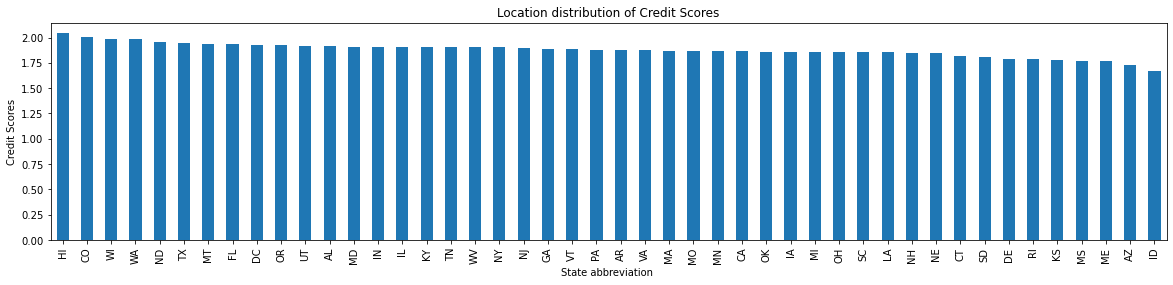

In [37]:
df1=SSN_To_Location(df)
df2=df1.groupby('abbreviation').mean()['Credit_Score']
df2.sort_values(ascending=False).plot(kind='bar', figsize=(20,4))
plt.title('Location distribution of Credit Scores')
plt.xlabel('State abbreviation ')
plt.ylabel('Credit Scores')

From the bar, HI(Hawaii) has the highest credit score and ID(Idaho) has the lowest credit score.

In [38]:
Credit_Score_Mapping(df2)

                           Credit Score distribution map (Black is the missing data place)

From the map, it's obvious that credit scores have greater variation in the West and they are more evenly distributed in the East.

As for the reason, we think it may be related to the economic level of different regions.

1) From the macroeconomic side, we used GDP per capita for mapping.

In [39]:
state_data=pd.read_excel('GDP per capita.xlsx')
state_data.rename(columns={'state':'Location'}, inplace=True)
df3 = pd.read_csv('state-abbrevs.csv') # Extra file
df3.columns=['Location','abbreviation']
state_data1=state_data.merge(df3,how="left")
state_data1

url = (
"https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
m = folium.Map(location=[43, -100], zoom_start=4)
folium.Choropleth(
geo_data=state_geo,
name="choropleth",
data=state_data1,
columns=['abbreviation',"GDP per capita"],
key_on="feature.id",
fill_color="YlOrRd",
fill_opacity=0.7,
line_opacity=0.2,
legend_name="Credit Score",
).add_to(m)

folium.LayerControl().add_to(m)

In [40]:
m

                                      GDP per capita location map

After mapping the GDP per capita geographical distribution, it’s found that it matches with scores distribution to some extent.


2) From the microeconomic level, we picked two indicators from the dataset: outstanding_debt and the monthly_inhand_salary

Text(0.5, 1.0, 'Outstanding_Debt and Credit Scores')

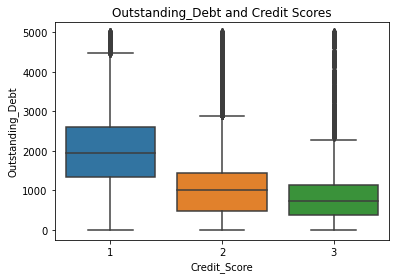

In [13]:
sns.boxplot(data=df, y="Outstanding_Debt", x="Credit_Score")
plt.title('Outstanding_Debt and Credit Scores')

From the boxplot, it's obvious that higher outstanding_debt distribution is in lower credit scores.

Text(0.5, 1.0, 'Monthly_Inhand_Salary and Credit Scores')

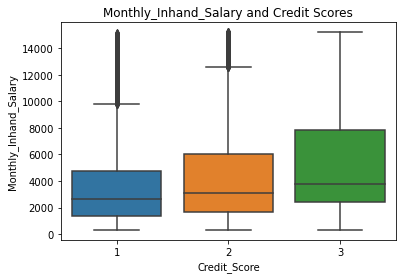

In [14]:
sns.boxplot(data=df, y="Monthly_Inhand_Salary", x="Credit_Score")
plt.title('Monthly_Inhand_Salary and Credit Scores')

From the boxplot, it's obvious that higher monthly inhand salary distribution is in higher credit scores.

Then it comes to the quantitative analysis part, which includes Machine learning.


# 4. Machine Learning

## 4.1 Load data and preprocessing data for ML

In [32]:
df = pd.read_csv('Cleaned_data.csv')

In [33]:
df[:5]

,Unnamed: 0,Customer_ID,Month,Name,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,...,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Payday Loan,Personal Loan,Student Loan,Not Specified,no loan,Payment_Behaviour_spent,Payment_Behaviour_value_payments
0,0,CUS_0xd40,January,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3,4,...,0,1,0,0,1,0,0,0,2,1
1,1,CUS_0xd40,February,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3,4,...,0,1,0,0,1,0,0,0,1,3
2,2,CUS_0xd40,March,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3,4,...,0,1,0,0,1,0,0,0,1,2
3,3,CUS_0xd40,April,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3,4,...,0,1,0,0,1,0,0,0,1,1
4,4,CUS_0xd40,May,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3,4,...,0,1,0,0,1,0,0,0,2,2


In [34]:
#encode data 
data = df.copy()
le = LabelEncoder()
for i in data.columns:
    if (data[i].dtypes== 'object') :
        data[i] = le.fit_transform(data[i])

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97751 entries, 0 to 97750
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        97751 non-null  int64  
 1   Customer_ID                       97751 non-null  int64  
 2   Month                             97751 non-null  int64  
 3   Name                              97751 non-null  int64  
 4   Age                               97751 non-null  float64
 5   SSN                               97751 non-null  int64  
 6   Annual_Income                     97751 non-null  float64
 7   Monthly_Inhand_Salary             97751 non-null  float64
 8   Num_Bank_Accounts                 97751 non-null  int64  
 9   Num_Credit_Card                   97751 non-null  int64  
 10  Interest_Rate                     97751 non-null  float64
 11  Num_of_Loan                       97751 non-null  int64  
 12  Type

In [7]:
data.head()

,Customer_ID,Month,Name,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Payday Loan,Personal Loan,Student Loan,Not Specified,no loan
0,12190,3,82,23,10100,19114.12,1824.843333,3,4,3,...,1,1,0,1,0,0,1,0,0,0
1,12190,2,82,23,10100,19114.12,1824.843333,3,4,3,...,1,1,0,1,0,0,1,0,0,0
2,12190,6,82,23,10100,19114.12,1824.843333,3,4,3,...,1,1,0,1,0,0,1,0,0,0
3,12190,0,82,23,10100,19114.12,1824.843333,3,4,3,...,1,1,0,1,0,0,1,0,0,0
4,12190,7,82,23,10100,19114.12,1824.843333,3,4,3,...,1,1,0,1,0,0,1,0,0,0


Exclude "Customer_ID","Name",and "SSN" features.

In [8]:
#split data
train, test = train_test_split(data, test_size = 0.3)
x_train = train.drop(['Credit_Score',"Customer_ID","Name","SSN"], axis=1)
y_train = train['Credit_Score']
x_test = test.drop(['Credit_Score',"Customer_ID","Name","SSN"], axis=1)
y_test = test['Credit_Score']

In [9]:
X = x_train
y = y_train
names = X.columns
names

Index(['Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Payment_Behaviour_spent', 'Payment_Behaviour_value_payments',
       'Accountant', 'Architect', 'Developer', 'Doctor', 'Engineer',
       'Entrepreneur', 'Journalist', 'Lawyer', 'Manager', 'Mechanic',
       'Media_Manager', 'Musician', 'Scientist', 'Teacher', 'Writer',
       'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan',
       'Home Equity Loan', 'Mortgage Loan', 'Payday Loan', 'Personal Loan',
       'Student Loan', 'Not Specified', 'no loan'],
      dtype='object')

In [10]:
y_test.unique()

array([2, 1, 3])

## 4.2 Visualization 

### distribution of the target variables

<AxesSubplot:xlabel='Credit_Score', ylabel='count'>

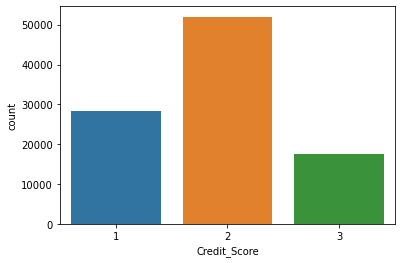

In [11]:
sns.countplot(x="Credit_Score", data = df)

Numbers of samples for three credut_score are not balanced, which may cause imbalanced problem

### Correlation heatmap

<AxesSubplot:>

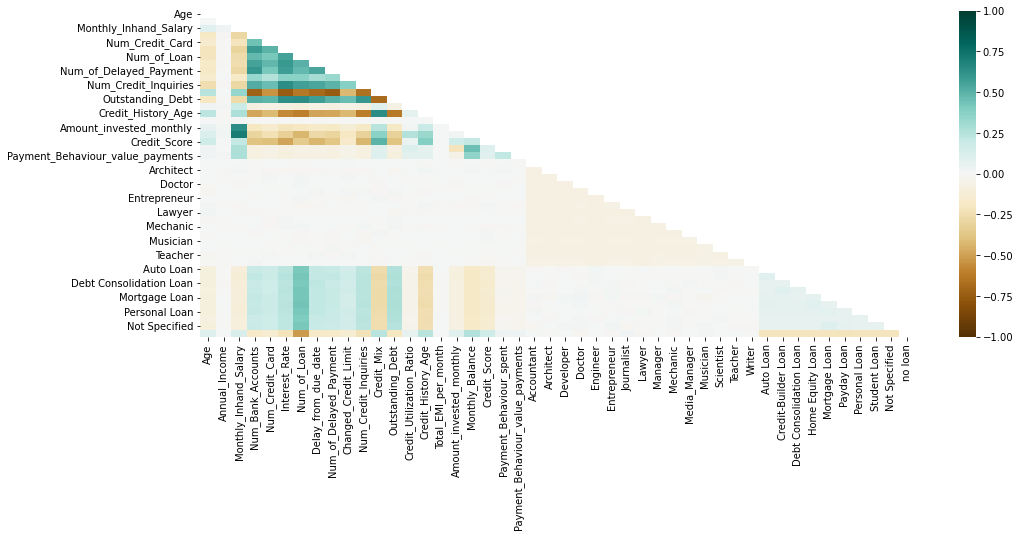

In [12]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(),vmin=-1, vmax=1,cmap='BrBG',mask=mask)


In [13]:
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column]) > 0.8)]
to_drop

[]

Thus, no variable will be dropped due to high correlation

## 4.3 logistic regression

### feature selection

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lgr1 = LogisticRegression()
lgr2 = LogisticRegression()

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)

clf = LogisticRegression(random_state = 0)
clf.fit(X_scaled, y)

LogisticRegression(random_state=0)

In [32]:
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

In [33]:
for idx in sorted_idx[::-1]:
    print('feature: ',names[idx],', with importance: ', feature_importance[idx])

feature:  Interest_Rate , with importance:  100.0
feature:  Changed_Credit_Limit , with importance:  88.58071618447208
feature:  Num_Credit_Card , with importance:  83.52936219902227
feature:  Delay_from_due_date , with importance:  83.16958913056027
feature:  Num_Credit_Inquiries , with importance:  72.53785848648383
feature:  Outstanding_Debt , with importance:  49.368590496491265
feature:  Payment_Behaviour_spent , with importance:  40.52831637681351
feature:  Credit_History_Age , with importance:  38.552663806966684
feature:  Amount_invested_monthly , with importance:  34.937906919283854
feature:  Payment_Behaviour_value_payments , with importance:  24.25373120576661
feature:  Monthly_Balance , with importance:  22.517765795557985
feature:  Monthly_Inhand_Salary , with importance:  19.705540888099815
feature:  Credit_Mix , with importance:  16.66094028317192
feature:  Num_of_Delayed_Payment , with importance:  15.937362625288076
feature:  no loan , with importance:  14.650605998165

More visually, show it in a histogram

Text(0.5, 0, 'Feature Selection for logistic regression')

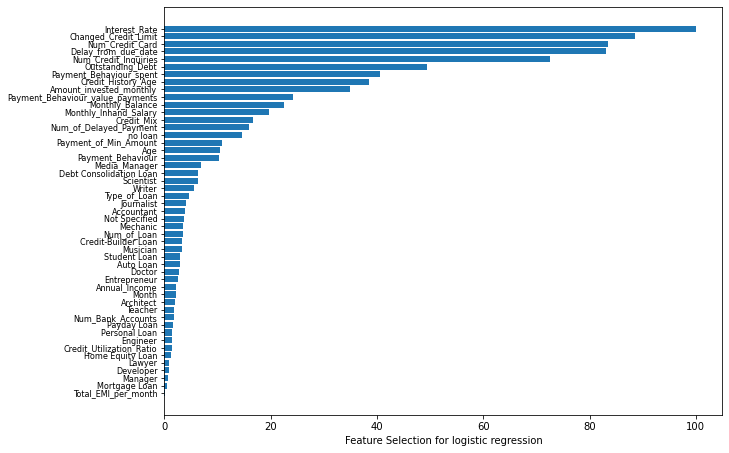

In [34]:
pos = np.arange(sorted_idx.shape[0]) + .5
featfig = plt.figure(figsize=(10, 7.5))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Feature Selection for logistic regression')

only use the top 10 features

In [35]:
feature = []
for i, idx in enumerate(sorted_idx[::-1]):
    if i < 10:
        feature.append(names[idx])
feature

['Interest_Rate',
 'Changed_Credit_Limit',
 'Num_Credit_Card',
 'Delay_from_due_date',
 'Num_Credit_Inquiries',
 'Outstanding_Debt',
 'Payment_Behaviour_spent',
 'Credit_History_Age',
 'Amount_invested_monthly',
 'Payment_Behaviour_value_payments']

In [36]:
x_train_lg = train[feature]
y_train_lg = train['Credit_Score']
x_test_lg = test[feature]
y_test_lg = test['Credit_Score']

In [37]:
#use all features
lgr1.fit(x_train , y_train)
lgr1.score(x_train, y_train)

0.5447862623310193

In [38]:
lgr1.score(x_test, y_test)

0.5475346109254586

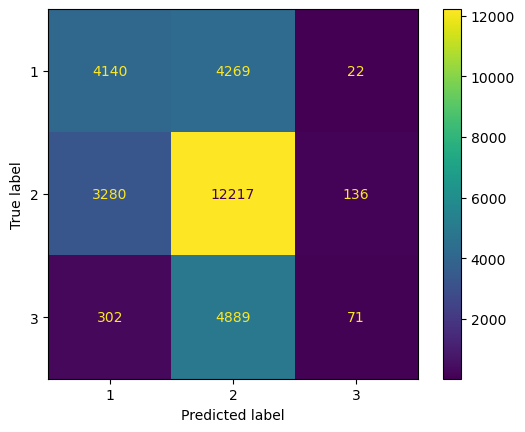

In [23]:
#plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lgr1,x_test, y_test,values_format='d' )

In [39]:
#use selected features
lgr2.fit(x_train_lg , y_train_lg)
lgr2.score(x_train_lg, y_train_lg)

0.6185458531238582

In [40]:
lgr2.score(x_test_lg, y_test_lg)

0.6195867148605333

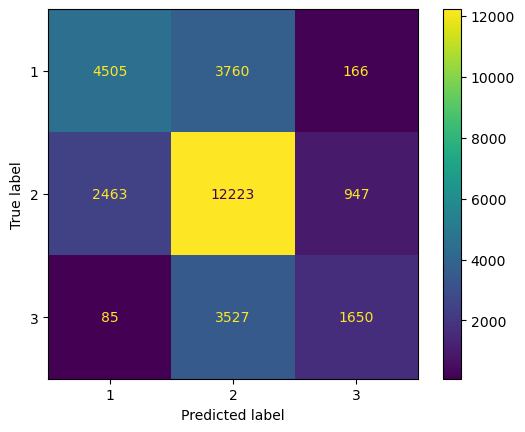

In [26]:
#plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lgr2,x_test_lg, y_test_lg,values_format='d' )

all features vs. selected features

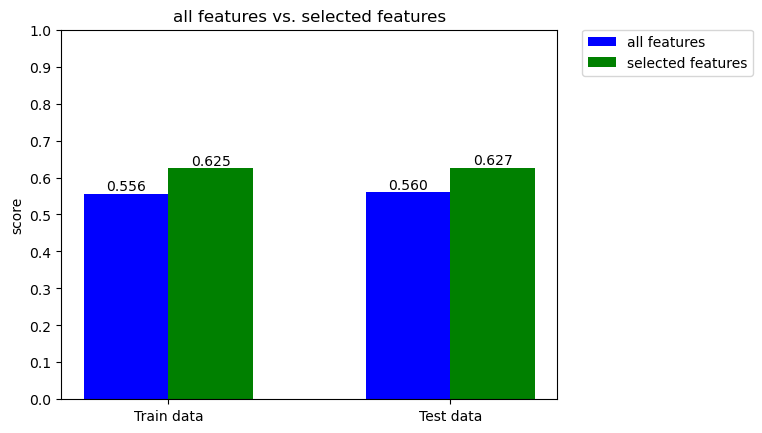

In [27]:
import matplotlib.pyplot as plt
import numpy as np 
name_list = ['Train data','Test data']
score_list1 = [lgr1.score(x_train, y_train),lgr1.score(x_test, y_test)]
score_list2 = [lgr2.score(x_train_lg, y_train_lg), lgr2.score(x_test_lg, y_test_lg)]

bar_width = 0.3  
index_1 = np.arange(len(name_list))  
index_2 = index_1 + bar_width 

plt.bar(index_1, height=score_list1, width=bar_width, color='b', label='all features')
plt.bar(index_2, height=score_list2, width=bar_width, color='g', label='selected features')

plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.xticks(index_1 + bar_width/2, name_list)  
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('score')  
plt.title('all features vs. selected features')  
for a,b in zip(index_1, score_list1):
    plt.text(a,b,
             '%.3f'%float(b),
             ha='center', 
             va='bottom',
            )
for a,b in zip(index_2, score_list2):
    plt.text(a,b,
             '%.3f'%float(b),
             ha='center', 
             va='bottom',
            )
plt.show()

### Logistic regression parameters tuning

In [28]:
#use all features
from sklearn.model_selection import GridSearchCV
#smaller C specify stronger regularization
parameters={'C': [0.001, 0.01, 0.1, 1, 10, 100],'penalty': ['l1', 'l2']}
model = GridSearchCV(LogisticRegression(),parameters,cv=3)
model.fit(x_train, y_train)
model.best_score_, model.best_params_

(0.5406210949629505, {'C': 0.001, 'penalty': 'l2'})

In [29]:
lgr3=LogisticRegression(C=10,penalty="l2")
lgr3.fit(x_train, y_train)
lgr3.score(x_train, y_train)

0.5381074168797954

In [30]:
lgr3.score(x_test, y_test)

0.5419423037577576

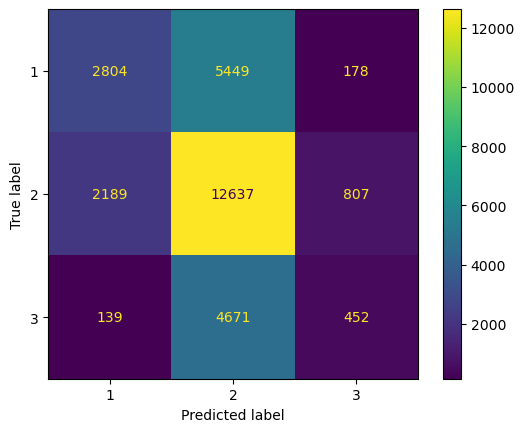

In [31]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lgr3,x_test, y_test,values_format='d' )

In [32]:
#use selected features
from sklearn.model_selection import GridSearchCV
#smaller C specify stronger regularization
parameters={'C': [0.001, 0.01, 0.1, 1, 10, 100],'penalty': ['l1', 'l2']}
model = GridSearchCV(LogisticRegression(),parameters,cv=3)
model.fit(x_train_lg, y_train_lg)
model.best_score_, model.best_params_

(0.6252100439337388, {'C': 0.1, 'penalty': 'l2'})

In [33]:
lgr4=LogisticRegression(C=0.1,penalty="l2")
lgr4.fit(x_train_lg, y_train_lg)
lgr4.score(x_train_lg, y_train_lg)

0.6249616368286445

In [34]:
lgr4.score(x_test_lg, y_test_lg)

0.6266111982541089

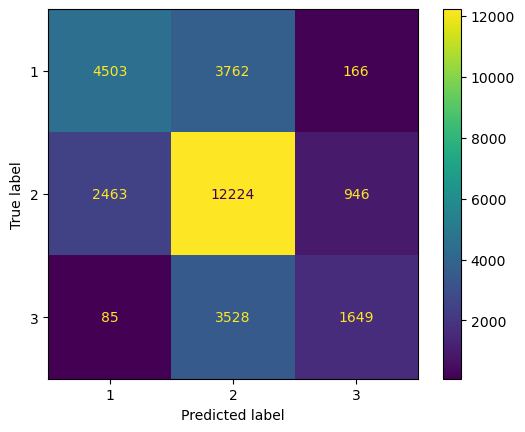

In [35]:
#plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lgr4,x_test_lg, y_test_lg,values_format='d' )

Score for logistic regression is low, move to next model.

## 4.4 knn

In [89]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier()
knn2= KNeighborsClassifier()

In [90]:
%matplotlib inline
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [115]:
#use data before deal with feature 'occupation'
df_deop = pd.read_csv('cleaned.csv',index_col=0)
#encode data 
data_deop = df_deop.copy()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in data_deop.columns:
    if (data_deop[i].dtypes== 'object') :
        data_deop[i] = le.fit_transform(data_deop[i])
#split data
from sklearn.model_selection import train_test_split
train_deop, test_deop = train_test_split(data, test_size = 0.3)
x_train_deop = train_deop.drop(['Credit_Score',"Customer_ID","Name","SSN"], axis=1)
y_train_deop = train_deop['Credit_Score']
x_test_deop = test_deop.drop(['Credit_Score',"Customer_ID","Name","SSN"], axis=1)
y_test_deop_deop = test_deop['Credit_Score']
X_deop = x_train_deop
y_deop = y_train_deop

In [91]:
# Forward Stepwise Selection for features
#reference from https://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html
import time
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = KNeighborsClassifier()
    knn = model.fit(X_deop[list(feature_set)],y_deop)
    RSS = ((knn.predict(X_deop[list(feature_set)]) - y_deop) ** 2).sum()
    return {"model":knn, "RSS":RSS, "features":feature_set}

def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_deop.columns if p not in predictors]   
    tic = time.time()   
    results = []
    for p in remaining_predictors:
        result_p = processSubset(predictors+[p])
        results.append(result_p)
#         print(result_p["features"])    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.iloc[models['RSS'].argmin()]
    print(best_model["features"])    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")   
    
    return best_model

In [112]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])
predictors = []
# k = len(X.columns)+1
k = 10
for i in range(1, k+1):  
    best_model = forward(predictors)
    models_fwd.loc[i] = best_model
    predictors = best_model["features"]

['Annual_Income']
Processed  25 models on 1 predictors in 80.17297720909119 seconds.
['Annual_Income', 'Credit_History_Age']
Processed  24 models on 2 predictors in 25.537167072296143 seconds.
['Annual_Income', 'Credit_History_Age', 'Type_of_Loan']
Processed  23 models on 3 predictors in 24.981653928756714 seconds.
['Annual_Income', 'Credit_History_Age', 'Type_of_Loan', 'Outstanding_Debt']
Processed  22 models on 4 predictors in 24.435335159301758 seconds.
['Annual_Income', 'Credit_History_Age', 'Type_of_Loan', 'Outstanding_Debt', 'Changed_Credit_Limit']
Processed  21 models on 5 predictors in 24.210216283798218 seconds.
['Annual_Income', 'Credit_History_Age', 'Type_of_Loan', 'Outstanding_Debt', 'Changed_Credit_Limit', 'Interest_Rate']
Processed  20 models on 6 predictors in 23.37015986442566 seconds.
['Annual_Income', 'Credit_History_Age', 'Type_of_Loan', 'Outstanding_Debt', 'Changed_Credit_Limit', 'Interest_Rate', 'Num_of_Loan']
Processed  19 models on 7 predictors in 22.590905189514

In [114]:
feature = predictors
feature

['Annual_Income',
 'Credit_History_Age',
 'Type_of_Loan',
 'Outstanding_Debt',
 'Changed_Credit_Limit',
 'Interest_Rate',
 'Num_of_Loan',
 'Credit_Mix',
 'Num_Bank_Accounts',
 'Num_Credit_Card']

In [111]:
x_train_knn = train[feature]
y_train_knn = train['Credit_Score']
x_test_knn = test[feature]
y_test_knn = test['Credit_Score']

In [43]:
#use all features
knn1.fit(x_train , y_train)
s1_train = knn1.score(x_train, y_train)

In [44]:
#test score
s1_test = knn1.score(x_test, y_test)

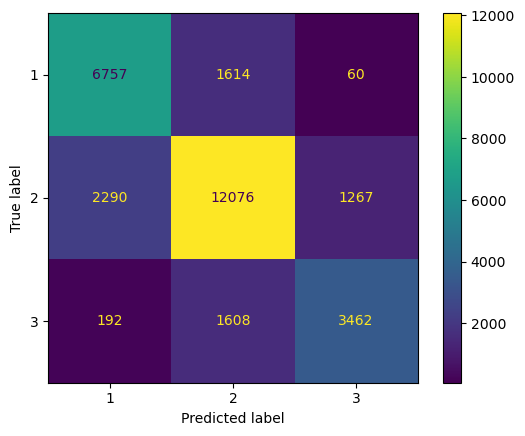

In [45]:
#plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn1,x_test, y_test,values_format='d' )

In [46]:
#use selected features
knn2.fit(x_train_knn, y_train_knn)
s2_train = knn2.score(x_train_knn, y_train_knn)

In [47]:
s2_test = knn2.score(x_test_knn, y_test_knn)

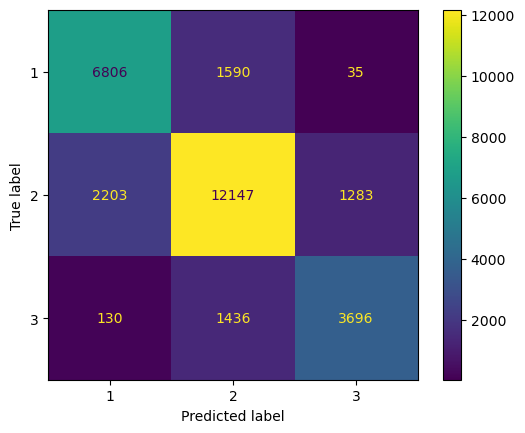

In [48]:
#plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn2,x_test_knn, y_test_knn,values_format='d' )

all features vs. selected features

In [49]:
print(s1_train, s1_test)
print(s2_train, s2_test)

0.8382316404822798 0.7602468799017936
0.8378662769455608 0.77231807951988


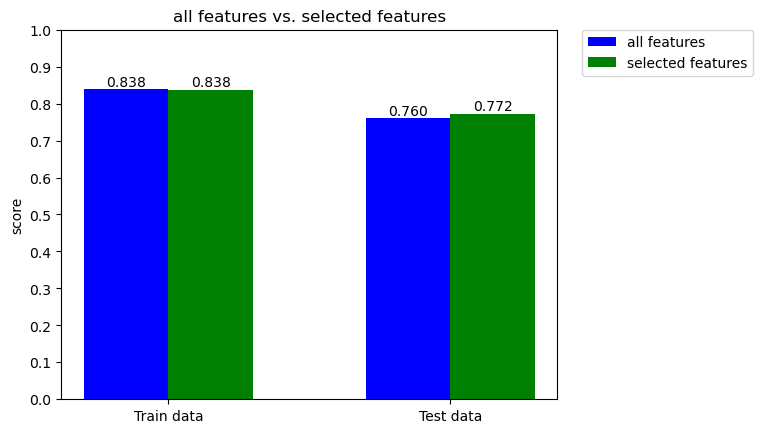

In [50]:
import matplotlib.pyplot as plt
import numpy as np 

name_list = ['Train data','Test data']
score_list1 = [s1_train, s1_test]
score_list2 = [s2_train, s2_test]

bar_width = 0.3  
index_1 = np.arange(len(name_list))  
index_2 = index_1 + bar_width 

plt.bar(index_1, height=score_list1, width=bar_width, color='b', label='all features')
plt.bar(index_2, height=score_list2, width=bar_width, color='g', label='selected features')

plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.xticks(index_1 + bar_width/2, name_list)    
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('score')  
plt.title('all features vs. selected features')  
for a,b in zip(index_1, score_list1):
    plt.text(a,b,
             '%.3f'%float(b),
             ha='center', 
             va='bottom',
            )
for a,b in zip(index_2, score_list2):
    plt.text(a,b,
             '%.3f'%float(b),
             ha='center', 
             va='bottom',
            )
plt.show()

We noticed that using selected festures will provide a higher test score. Then, we start tuning our parameters to improve our model score.

### KNN Parameter Tuning

In [51]:
#use all features
from sklearn import metrics
knn = KNeighborsClassifier()
mean_acc = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    yhat= knn.predict(x_test)
    mean_acc[i-1] = metrics.accuracy_score(y_test, yhat)

mean_acc

array([0.75206302, 0.75537066, 0.76754416, 0.76304303, 0.76024688,
       0.74476574, 0.73017118, 0.71134829, 0.69651504, 0.68440974,
       0.67247494, 0.66473437, 0.66016504, 0.65617541, 0.65235627,
       0.65249267, 0.64788925, 0.64601378, 0.64260383, 0.64188774])

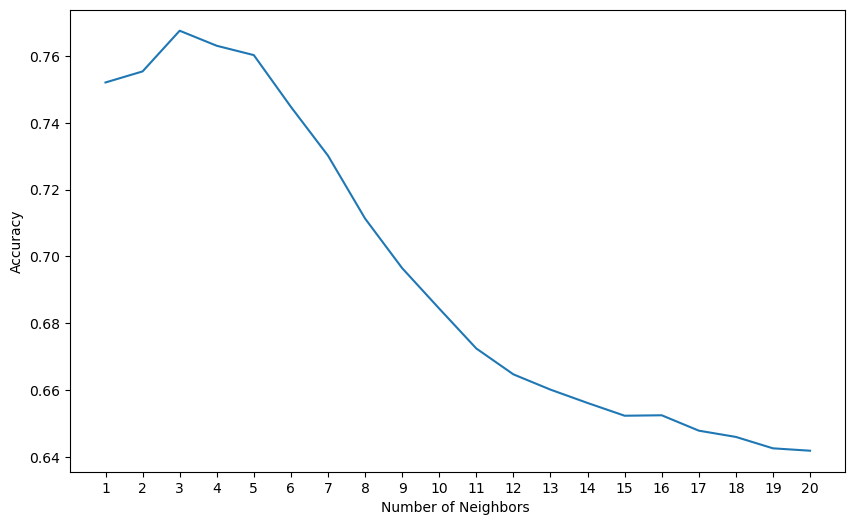

In [52]:
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

From the plot, we choose number of neighbors to be 3 and 5, and then explore other parameters

In [53]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [54]:
#use all features
parameters={'n_neighbors': [3,5],"leaf_size":[1,5,10,30]}
model = GridSearchCV(KNeighborsClassifier(),parameters,cv=3)
model.fit(x_train, y_train)
model.best_score_, model.best_params_

(0.7322177734264521, {'leaf_size': 1, 'n_neighbors': 3})

In [55]:
knn3=KNeighborsClassifier(leaf_size=1,n_neighbors=3)

In [56]:
knn3.fit(x_train, y_train)
knn3.score(x_train, y_train)

0.8727219583485568

In [57]:
knn3.score(x_test, y_test)

0.7675441587669645

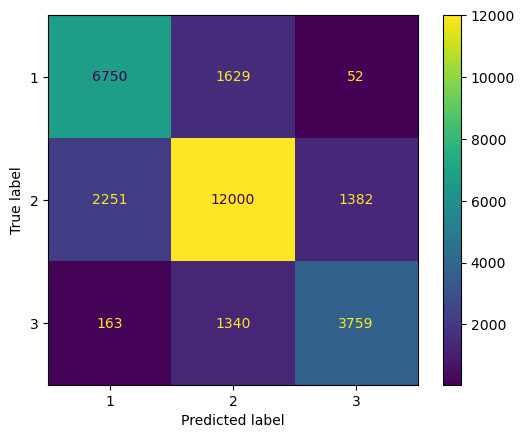

In [58]:
#plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn3,x_test, y_test,values_format='d' )

In [59]:
#use selected features
from sklearn import metrics
knn = KNeighborsClassifier()
mean_acc = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(x_train_knn, y_train_knn)
    yhat= knn.predict(x_test_knn)
    mean_acc[i-1] = metrics.accuracy_score(y_test_knn, yhat)

mean_acc

array([0.74619791, 0.75738253, 0.77473914, 0.77214758, 0.77231808,
       0.75462047, 0.73886653, 0.71400805, 0.69610584, 0.67735116,
       0.66180181, 0.65573211, 0.65146969, 0.65095819, 0.64911682,
       0.64785515, 0.6445134 , 0.64417241, 0.64192184, 0.64028507])

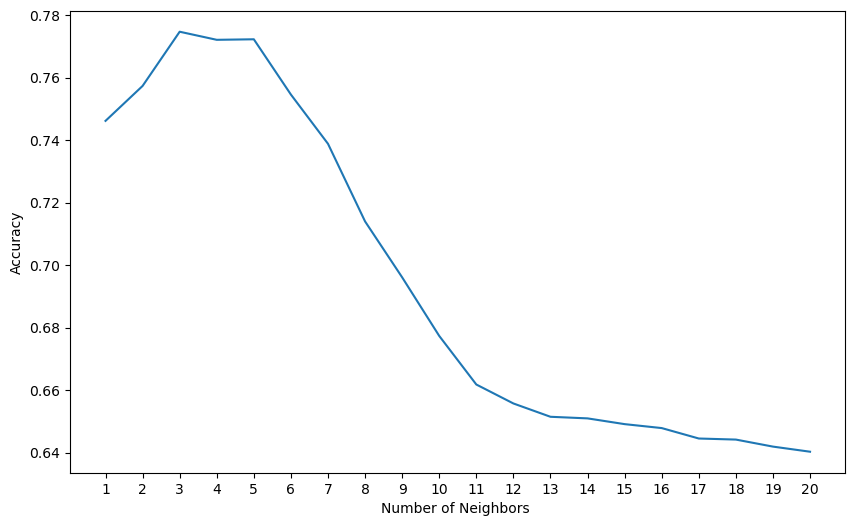

In [60]:
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

From the plot, we choose number of neighbors to be 3 and 5, and then explore other parameters

In [61]:
#use selected features
parameters={'n_neighbors': [3,5],"leaf_size":[1,5,10,30]}
model = GridSearchCV(KNeighborsClassifier(),parameters,cv=3)
model.fit(x_train_knn, y_train_knn)
model.best_score_, model.best_params_

(0.7424917700264126, {'leaf_size': 30, 'n_neighbors': 3})

In [62]:
knn4=KNeighborsClassifier(leaf_size=1,n_neighbors=3)

In [63]:
knn4.fit(x_train_knn, y_train_knn)
knn4.score(x_train_knn, y_train_knn)

0.8370770917062477

In [64]:
knn4.score(x_test_knn, y_test_knn)

0.7765464093296052

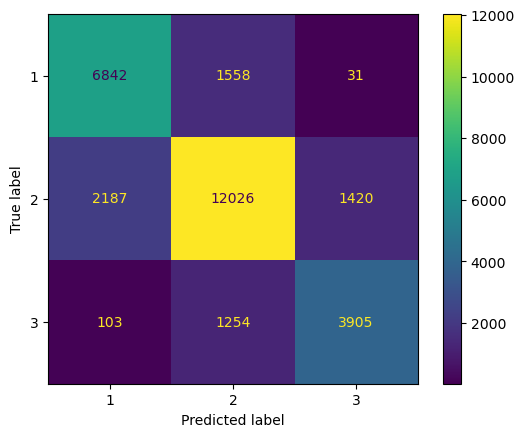

In [65]:
#plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn4,x_test_knn, y_test_knn,values_format='d' )

## 4.5 Decision trees

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
dtc1 = tree.DecisionTreeClassifier()
dtc2 = tree.DecisionTreeClassifier()

In [44]:
dtc1.fit(X, y)

DecisionTreeClassifier()

In [50]:
feature_importance = dtc1.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx

array([48, 38, 24, 34, 30, 27, 35, 25, 29, 33, 32, 31, 37, 28, 22, 36, 26,
       41, 40, 39, 43, 17, 42, 47, 44, 45, 46, 23,  7, 20,  4, 12,  2,  5,
        0,  3,  8,  1, 18, 10,  9, 21, 19, 15, 11, 16,  6, 13, 14])

In [51]:
for idx in sorted_idx[::-1]:
    print('feature: ',names[idx],', with importance: ', feature_importance[idx])

feature:  Outstanding_Debt , with importance:  0.16251523221460992
feature:  Credit_Mix , with importance:  0.1177317671895497
feature:  Interest_Rate , with importance:  0.06661948260251112
feature:  Credit_History_Age , with importance:  0.06006010619566311
feature:  Changed_Credit_Limit , with importance:  0.04566489938728506
feature:  Credit_Utilization_Ratio , with importance:  0.0421070037520039
feature:  Amount_invested_monthly , with importance:  0.040824736116101386
feature:  Monthly_Balance , with importance:  0.037951680373031496
feature:  Delay_from_due_date , with importance:  0.03779606219459289
feature:  Num_of_Delayed_Payment , with importance:  0.03318536102780763
feature:  Total_EMI_per_month , with importance:  0.03164736029375107
feature:  Age , with importance:  0.031194060044982996
feature:  Type_of_Loan , with importance:  0.029903634040971256
feature:  Monthly_Inhand_Salary , with importance:  0.028716676990811558
feature:  Month , with importance:  0.0281516110

More visually, show it in a histogram

Text(0.5, 0, 'Feature Selection for Decision trees')

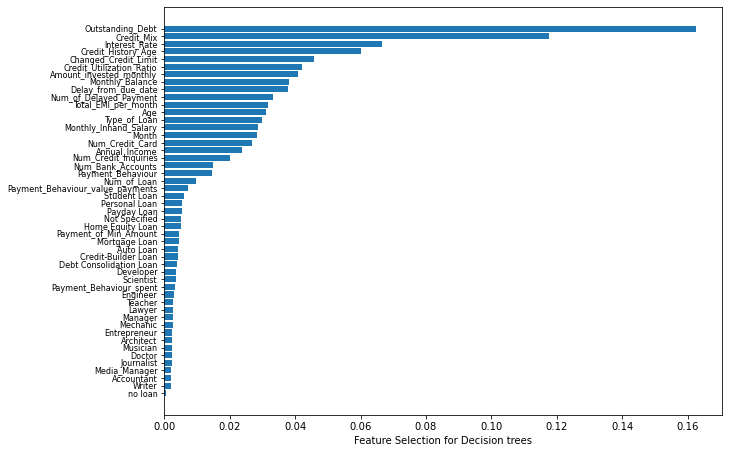

In [52]:
pos = np.arange(sorted_idx.shape[0]) + .5
featfig = plt.figure(figsize=(10, 7.5))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Feature Selection for Decision trees')

only use the top 10 features

In [54]:
feature = []
for i, idx in enumerate(sorted_idx[::-1]):
    if i > 10 :
        break
    feature.append(names[idx])
feature

['Outstanding_Debt',
 'Credit_Mix',
 'Interest_Rate',
 'Credit_History_Age',
 'Changed_Credit_Limit',
 'Credit_Utilization_Ratio',
 'Amount_invested_monthly',
 'Monthly_Balance',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Total_EMI_per_month']

In [55]:
x_train_dtc = train[feature]
y_train_dtc = train['Credit_Score']
x_test_dtc = test[feature]
y_test_dtc = test['Credit_Score']

In [73]:
#use all features
dtc1.fit(x_train , y_train)
s1_train = dtc1.score(x_train , y_train)

In [74]:
s1_test = dtc1.score(x_test , y_test)

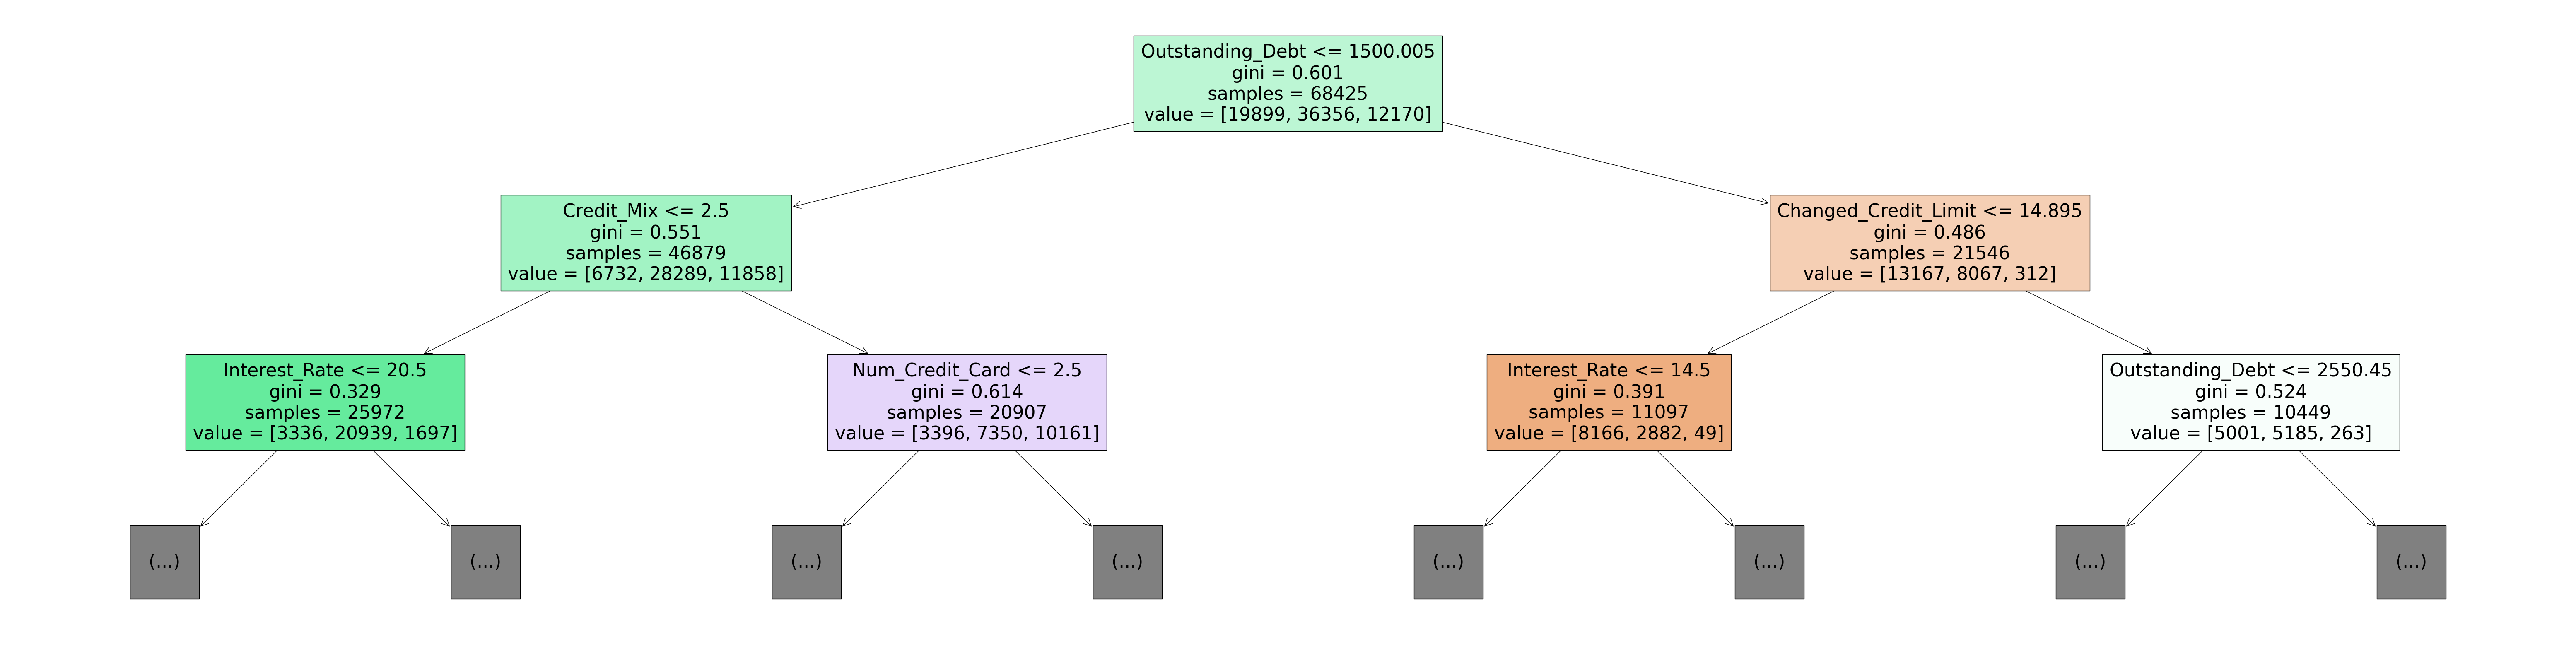

In [75]:
#Visualizing a Decision Tree
from sklearn.tree import plot_tree, export_text
plt.figure(figsize =(80,20))

plot_tree(dtc1,feature_names=x_train.columns,max_depth=2,filled=True);

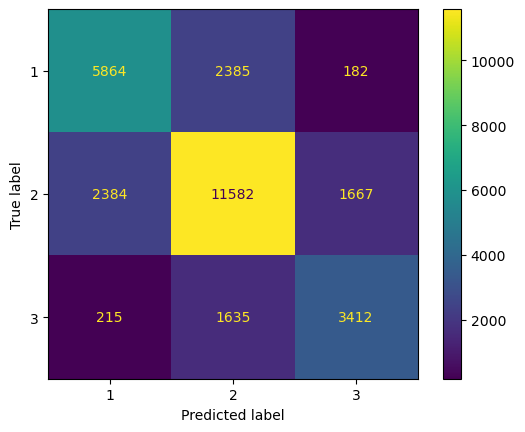

In [76]:
#plot confusion matrix
plot_confusion_matrix(dtc1,x_test, y_test,values_format='d' )

In [77]:
#use selected features
dtc2.fit(x_train_dtc, y_train_dtc)
s2_train = dtc2.score(x_train_dtc , y_train_dtc)

In [78]:
s2_test = dtc2.score(x_test_dtc , y_test_dtc)

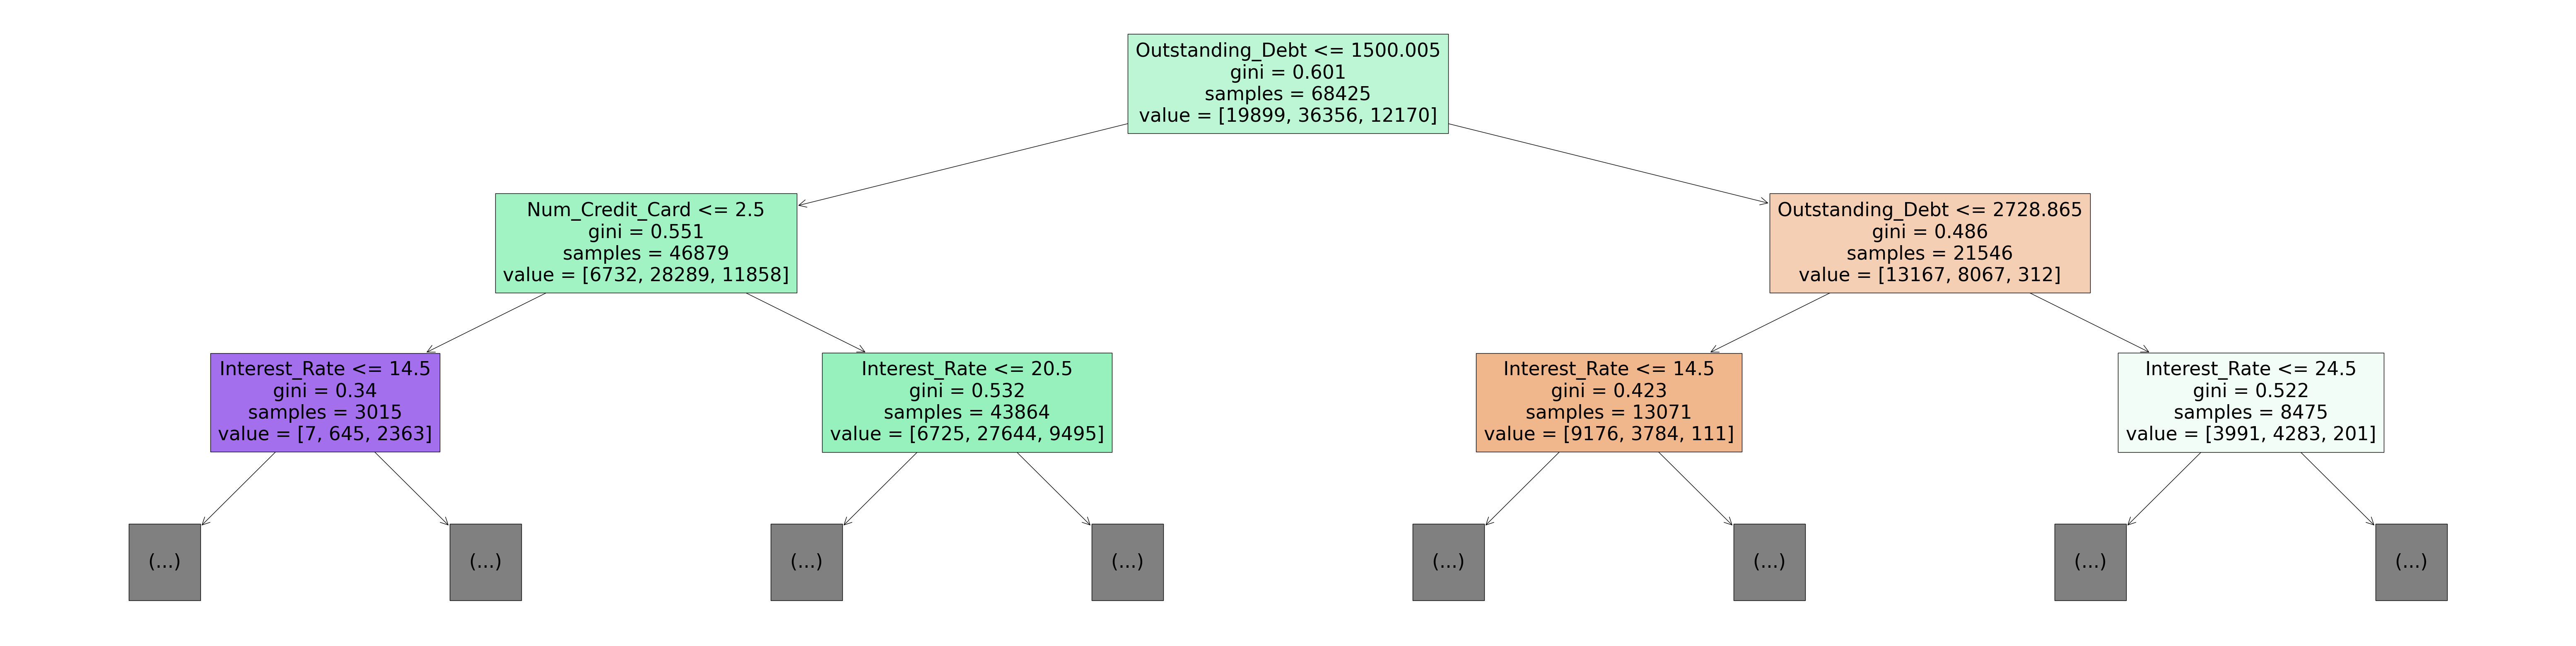

In [79]:
#Visualizing a Decision Tree
from sklearn.tree import plot_tree, export_text
plt.figure(figsize =(80,20))

plot_tree(dtc2,feature_names=x_train_dtc.columns,max_depth=2,filled=True);

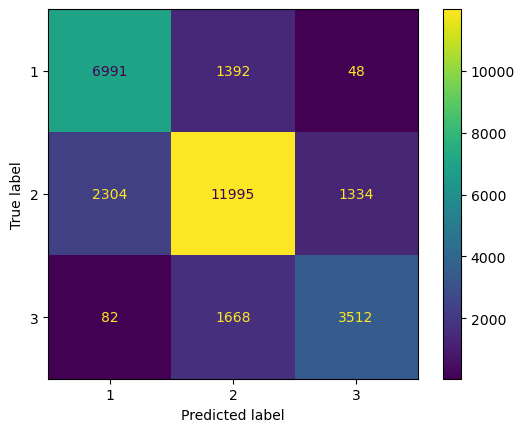

In [80]:
#plot confusion matrix
plot_confusion_matrix(dtc2,x_test_dtc,y_test_dtc,values_format='d' )

all features vs. selected features

In [81]:
print(s1_train, s1_test)
print(s2_train, s2_test)

1.0 0.711245993316511
0.92165144318597 0.7671690649935211


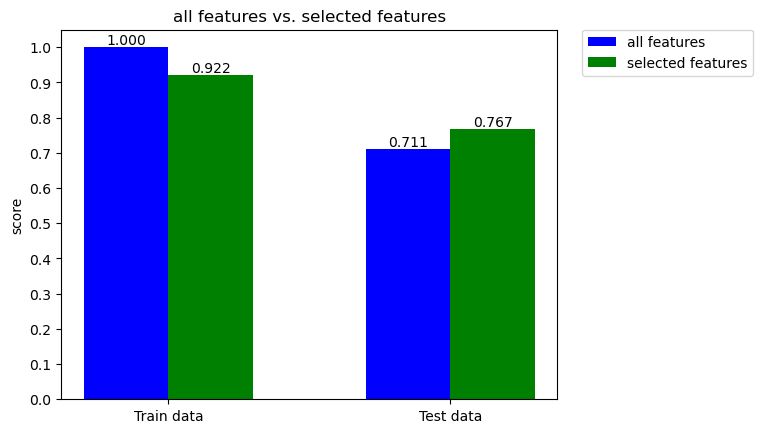

In [82]:
import matplotlib.pyplot as plt
import numpy as np 

name_list = ['Train data','Test data']
score_list1 = [s1_train, s1_test]
score_list2 = [s2_train, s2_test]

bar_width = 0.3  
index_1 = np.arange(len(name_list))  
index_2 = index_1 + bar_width 

plt.bar(index_1, height=score_list1, width=bar_width, color='b', label='all features')
plt.bar(index_2, height=score_list2, width=bar_width, color='g', label='selected features')

plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.xticks(index_1 + bar_width/2, name_list)    
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('score')  
plt.title('all features vs. selected features')  
for a,b in zip(index_1, score_list1):
    plt.text(a,b,
             '%.3f'%float(b),
             ha='center', 
             va='bottom',
            )
for a,b in zip(index_2, score_list2):
    plt.text(a,b,
             '%.3f'%float(b),
             ha='center', 
             va='bottom',
            )
plt.show()

### Decision Tree Parameter Tuning

In [83]:
#all feature
for max_d in range(10,15):
    model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
    model.fit(x_train , y_train)
    print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(x_train , y_train))
    print('The Validation Accuracy for max_depth {} is:'.format(max_d), model.score(x_test, y_test))
    print('')

The Training Accuracy for max_depth 10 is: 0.7419218122031421
The Validation Accuracy for max_depth 10 is: 0.7166337038805156

The Training Accuracy for max_depth 11 is: 0.7549579831932773
The Validation Accuracy for max_depth 11 is: 0.7216122212371274

The Training Accuracy for max_depth 12 is: 0.7678626233101936
The Validation Accuracy for max_depth 12 is: 0.7213735251994817

The Training Accuracy for max_depth 13 is: 0.7838217025940811
The Validation Accuracy for max_depth 13 is: 0.7233853918024961

The Training Accuracy for max_depth 14 is: 0.80165144318597
The Validation Accuracy for max_depth 14 is: 0.7236240878401419



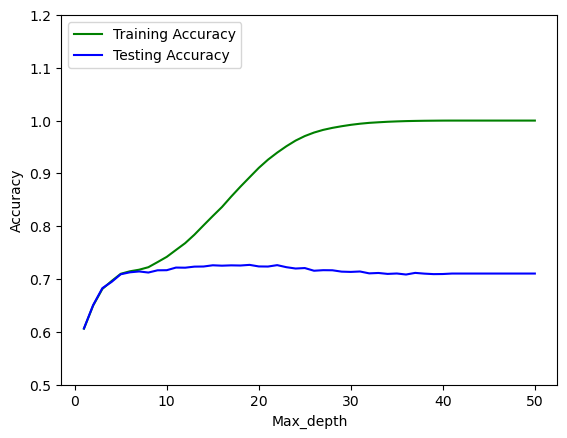

In [84]:
#visualize
depth=[]
train_score=[]
test_score=[]
for max_d in range(1,51):
    depth.append(max_d)
    model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
    model.fit(x_train , y_train)
    train_score.append(model.score(x_train , y_train))
    test_score.append(model.score(x_test, y_test))
import matplotlib.pyplot as plt
plt.plot(depth, train_score, "-g", label="Training Accuracy")
plt.plot(depth, test_score, "-b", label="Testing Accuracy")
plt.legend(loc="upper left")
plt.ylim(0.5, 1.2)
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.show()    

In [85]:
#selected feature
#max_depth effect 
for max_d in range(10,15):
    model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
    model.fit(x_train_dtc, y_train_dtc)
    print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(x_train_dtc, y_train_dtc))
    print('The Validation Accuracy for max_depth {} is:'.format(max_d), model.score(x_test_dtc,y_test_dtc))
    print('')

The Training Accuracy for max_depth 10 is: 0.7029302155644866
The Validation Accuracy for max_depth 10 is: 0.6856373184205142

The Training Accuracy for max_depth 11 is: 0.7147387650712459
The Validation Accuracy for max_depth 11 is: 0.6907181340789743

The Training Accuracy for max_depth 12 is: 0.7273072707343807
The Validation Accuracy for max_depth 12 is: 0.6986292027552342

The Training Accuracy for max_depth 13 is: 0.7414249177932042
The Validation Accuracy for max_depth 13 is: 0.7045284048284799

The Training Accuracy for max_depth 14 is: 0.7570332480818415
The Validation Accuracy for max_depth 14 is: 0.7141103457682603



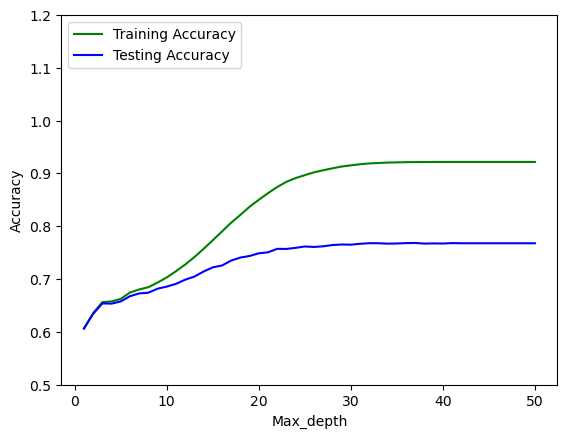

In [86]:
#visualize
depth=[]
train_score=[]
test_score=[]
for max_d in range(1,51):
    depth.append(max_d)
    model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
    model.fit(x_train_dtc, y_train_dtc)
    train_score.append(model.score(x_train_dtc, y_train_dtc))
    test_score.append(model.score(x_test_dtc,y_test_dtc))
import matplotlib.pyplot as plt
plt.plot(depth, train_score, "-g", label="Training Accuracy")
plt.plot(depth, test_score, "-b", label="Testing Accuracy")
plt.legend(loc="upper left")
plt.ylim(0.5, 1.2)
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.show()    

According to figure, when max_depth is too large, the overfitting problem occure.
While tuning the hyper-parameters of a single decision tree is giving us some improvement, a stratagem would be to merge the results of diverse decision trees with moderately different parameters. Thus, we do futher analysis with Random Forest. We also observed that max_depth around 10 is appropriate for model using all features, and  max_depth around 20 is appropriate for model using selected features. We plug in those two number to following random forest model.

## 4.6 Random forest

In [65]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
# n_estimators, max_depth
rf1 = RandomForestClassifier(n_estimators=20, max_depth=10)
rf2 = RandomForestClassifier(n_estimators=20, max_depth=20)

In [66]:
rf1.fit(X, y)

RandomForestClassifier(max_depth=10, n_estimators=20)

In [67]:
feature_importance = rf1.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx

array([31, 30, 37, 25, 28, 24, 33, 29, 32, 38, 34, 35, 27, 36, 26, 23, 44,
       48, 47, 42, 22, 41, 43, 45, 39, 40, 46, 20,  0, 15,  1, 19, 21,  8,
       18,  3,  2,  7, 10, 11,  4, 17, 16,  5, 12,  9,  6, 13, 14])

In [68]:
for idx in sorted_idx[::-1]:
    print('feature: ',names[idx],', with importance: ', feature_importance[idx])

feature:  Outstanding_Debt , with importance:  0.20389369522920983
feature:  Credit_Mix , with importance:  0.15938735686910552
feature:  Interest_Rate , with importance:  0.10390558915948987
feature:  Delay_from_due_date , with importance:  0.06073445317100522
feature:  Num_Credit_Inquiries , with importance:  0.05826732603540323
feature:  Num_Credit_Card , with importance:  0.05773478979030591
feature:  Credit_History_Age , with importance:  0.049797996556031704
feature:  Payment_of_Min_Amount , with importance:  0.04761846761327708
feature:  Num_Bank_Accounts , with importance:  0.047021279511892486
feature:  Changed_Credit_Limit , with importance:  0.04050596437457583
feature:  Num_of_Delayed_Payment , with importance:  0.02884642081526174
feature:  Num_of_Loan , with importance:  0.020209284378204417
feature:  Annual_Income , with importance:  0.015115124530066448
feature:  Monthly_Inhand_Salary , with importance:  0.013972792674166745
feature:  Total_EMI_per_month , with importan

More visually, show it in a histogram

Text(0.5, 0, 'Feature Selection for logistic regression')

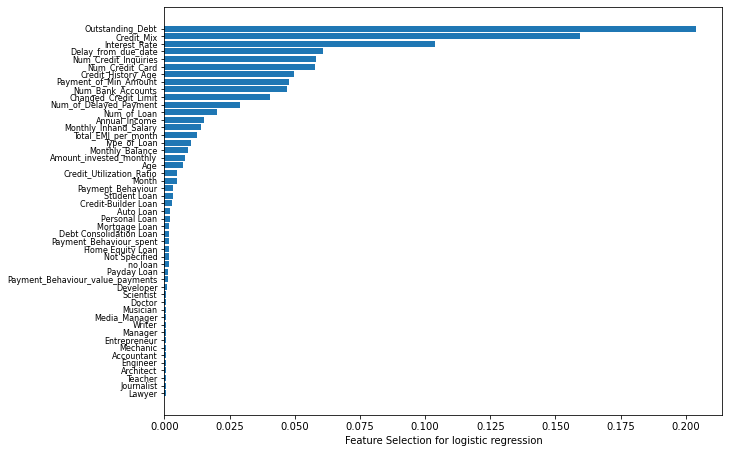

In [69]:
pos = np.arange(sorted_idx.shape[0]) + .5
featfig = plt.figure(figsize=(10, 7.5))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Feature Selection for logistic regression')

only use the top 10 features

In [70]:
feature = []
for i, idx in enumerate(sorted_idx[::-1]):
    if i > 10 :
        break
    feature.append(names[idx])
feature

['Outstanding_Debt',
 'Credit_Mix',
 'Interest_Rate',
 'Delay_from_due_date',
 'Num_Credit_Inquiries',
 'Num_Credit_Card',
 'Credit_History_Age',
 'Payment_of_Min_Amount',
 'Num_Bank_Accounts',
 'Changed_Credit_Limit',
 'Num_of_Delayed_Payment']

In [71]:
x_train_rf = train[feature]
y_train_rf = train['Credit_Score']
x_test_rf = test[feature]
y_test_rf = test['Credit_Score']

In [72]:
#use all features
rf1.fit(x_train, np.ravel(y_train))
s1_train = rf1.score(x_train,y_train)

In [73]:
s1_test = rf1.score(x_test,y_test)

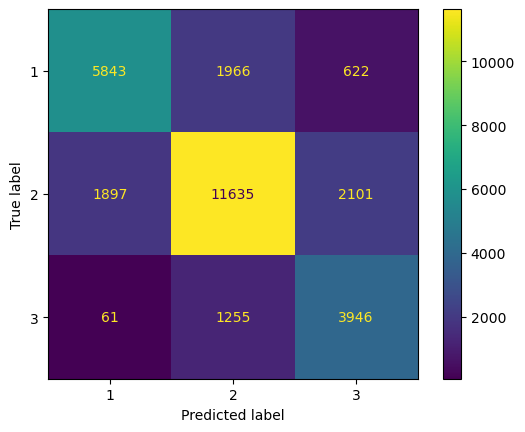

In [96]:
#plot confusion matrix
plot_confusion_matrix(rf1,x_test, y_test,values_format='d' )

In [75]:
#use selected features
rf2.fit(x_train_rf, np.ravel(y_train_rf))
s2_train = rf2.score(x_train_rf,y_train_rf)

In [76]:
s2_test = rf2.score(x_test_rf,y_test_rf)

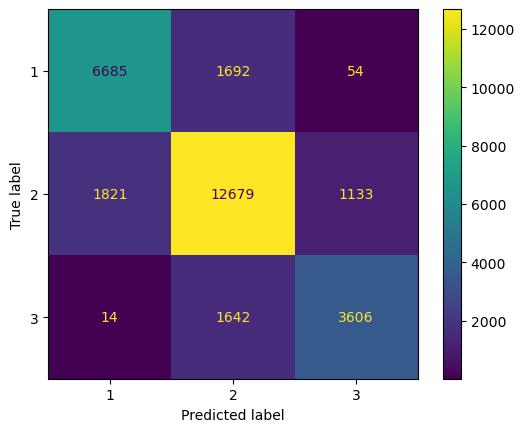

In [99]:
#plot confusion matrix
plot_confusion_matrix(rf2,x_test_rf, y_test_rf,values_format='d' )

all features vs. selected features

In [77]:
print(s1_train, s1_test)
print(s2_train, s2_test)

0.7522542930215564 0.722260110482166
0.9348045305078553 0.7927095410216191


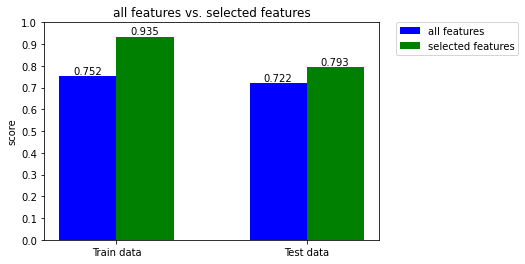

In [78]:
import matplotlib.pyplot as plt
import numpy as np 

name_list = ['Train data','Test data']
score_list1 = [s1_train, s1_test]
score_list2 = [s2_train, s2_test]

bar_width = 0.3  
index_1 = np.arange(len(name_list))  
index_2 = index_1 + bar_width 

plt.bar(index_1, height=score_list1, width=bar_width, color='b', label='all features')
plt.bar(index_2, height=score_list2, width=bar_width, color='g', label='selected features')

plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.xticks(index_1 + bar_width/2, name_list)    
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('score')  
plt.title('all features vs. selected features')  
for a,b in zip(index_1, score_list1):
    plt.text(a,b,
             '%.3f'%float(b),
             ha='center', 
             va='bottom',
            )
for a,b in zip(index_2, score_list2):
    plt.text(a,b,
             '%.3f'%float(b),
             ha='center', 
             va='bottom',
            )
plt.show()

### Random Forest parameter tuning

In [102]:
#use all features
from sklearn.ensemble import RandomForestClassifier
parameters={'n_estimators': [10,50,100],"min_samples_split":[1,10,20]}
model = GridSearchCV(RandomForestClassifier(n_jobs = -1),parameters,cv=3)
model.fit(x_train, y_train)
model.best_score_, model.best_params_

(0.7878114930418388, {'min_samples_split': 10, 'n_estimators': 100})

In [103]:
model.score(x_test,y_test)

0.8035872604514765

In [104]:
#choose n_estimators=100
from sklearn.ensemble import RandomForestClassifier
rf3 = RandomForestClassifier(random_state = 24, n_jobs = -1,n_estimators=100,min_samples_split=10)
rf3.fit(x_train,y_train)
rf3.score(x_train,y_train)

0.9336938253562295

In [105]:
rf3.score(x_test,y_test)

0.8057696242242379

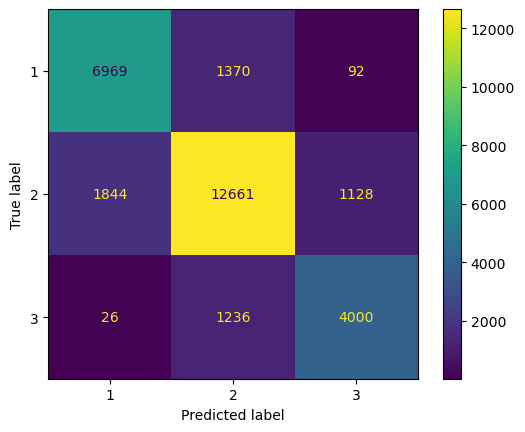

In [106]:
#plot confusion matrix
plot_confusion_matrix(rf3,x_test, y_test,values_format='d' )

In [107]:
#use selected features
from sklearn.ensemble import RandomForestClassifier
parameters={'n_estimators': [10,50,100],"min_samples_split":[1,10,20]}
model = GridSearchCV(RandomForestClassifier(n_jobs = -1),parameters,cv=3)
model.fit(x_train_rf, np.ravel(y_train_rf))
model.best_score_, model.best_params_

(0.7763098070389972, {'min_samples_split': 10, 'n_estimators': 100})

In [108]:
from sklearn.ensemble import RandomForestClassifier
rf4 = RandomForestClassifier(random_state = 24, n_jobs = -1,n_estimators=100,min_samples_split=10)
rf4.fit(x_train_rf, np.ravel(y_train_rf))
rf4.score(x_train_rf, np.ravel(y_train_rf))

0.8787869930580928

In [109]:
rf4.score(x_test_rf, y_test_rf)

0.7939371206437973

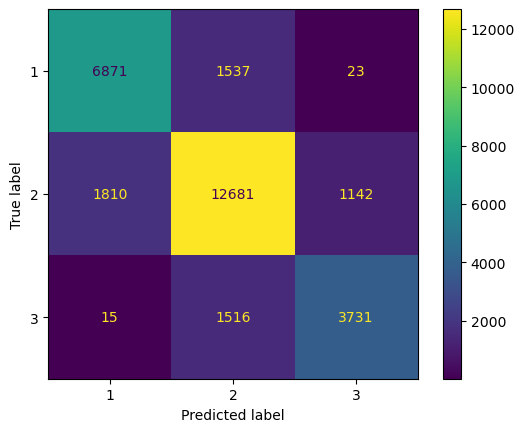

In [110]:
#plot confusion matrix
plot_confusion_matrix(rf4,x_test_rf, y_test_rf,values_format='d' )

# 5. Conclusion

1）From the macroeconomic side, credit scores are related with GDP per capita and 'Interest_Rate'; from the microeconomic side, the most important features are 'Outstanding_Debt', 'Credit_Mix', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Num_Credit_Card', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Num_Bank_Accounts', 'Changed_Credit_Limit', and 'Num_of_Delayed_Payment' from Random Forest Model (80.53% Precision).


2）We can see that credit scores have little relationship with the occupation itself (not including salary) and the loan type. Therefore, our prediction models can be used for different loan types (appear in the dataset) and help financial institutes to estimate the default risk of its customers.


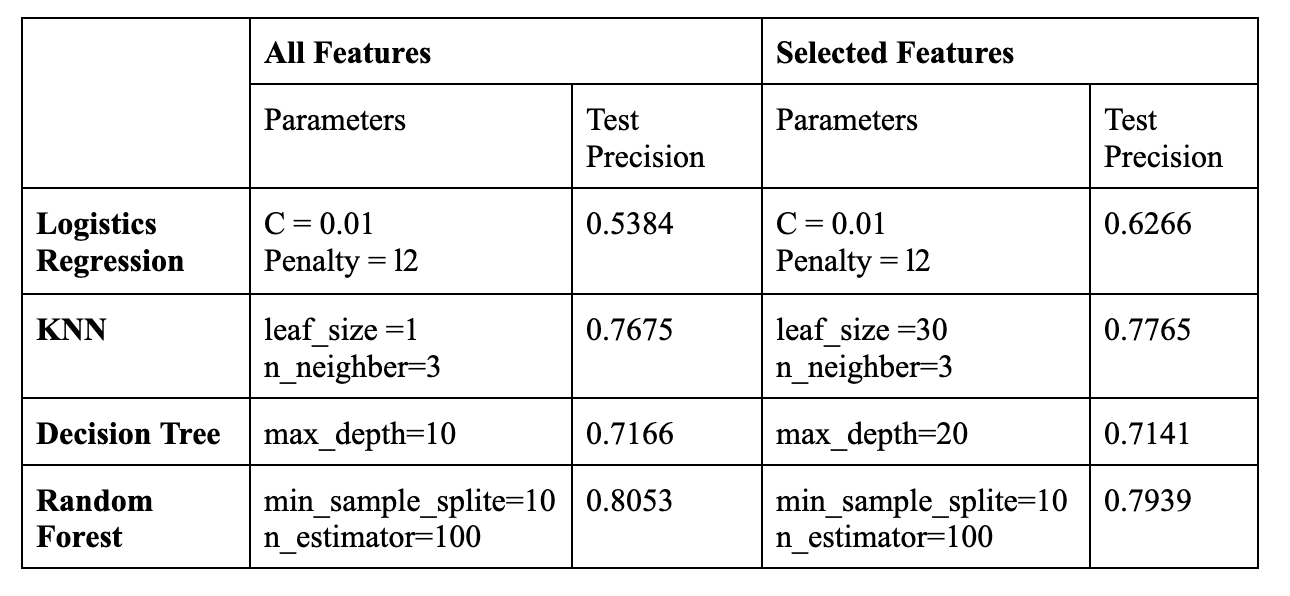

# 6. Limitation and Future Works

1） Improvements after presentation for feature selection：
We used cross validation to select features for each model above by calculating their R2 before. By sorting the score of R2 for each feature, we only select the features with positive scores. However, we find that some features with negative scores are supposed to be important to the prediction under the guidance of the professor.
Therefore, we try to use other valid methods to select features. For logistic regression, we take the coefficients of features as their importance. For decision trees and random forest, we use the attributes ‘feature_importances_’ of the model to select features. For KNN, we use the algorithm called forward stepwise selection to select a feature set. There are some common features along all selected features by four models, which seems to be more convincing.



2）Future Improvements for feature selection：
The data after cleaning has too many features to select, especially after cleaning the column ‘Occupation’, which is really time-consuming for KNN to do feature selection. Therefore, we just use the data before cleaning the column ‘Occupation’ to select features on KNN. 
